# 🧪 Scientific Graph Agent - Advanced Demo

This notebook demonstrates **advanced LangGraph features**: streaming, interrupts (human-in-the-loop), and time travel (state rewinding/branching).

**Prerequisites**: Familiarity with basic LangGraph concepts (nodes, edges, state). See `demo_basic.ipynb` for fundamentals.

In [1]:
import os
import logging
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Reduce logging noise for cleaner output
logging.getLogger().setLevel(logging.WARNING)

# Auto-reload modules when they change (useful during development)
%load_ext autoreload
%autoreload 2

In [2]:
LLM_MODEL = "gpt-5-mini"

In [3]:
# Verify that API keys are set
if not os.getenv("OPENAI_API_KEY"):
    raise ValueError("⚠️  OPENAI_API_KEY not found in .env file")

print("✅ Environment variables loaded")

✅ Environment variables loaded


In [4]:
cd ..

/Users/linafaik/Documents/projects/scientific-graph-agent


## Graph Initialization

**Key concept**: `with_checkpointer=True` enables **persistence** - the graph saves state snapshots after each node.

This is required for:
- 🔴 **Interrupts** (pausing/resuming execution)
- ⏪ **Time travel** (accessing historical states)
- 🔄 **Multi-turn conversations** (maintaining context across runs)

In [5]:
from src.agent_graph.graph import create_streaming_graph

# Create graph with async support for streaming
# with_checkpointer=True → Enables persistence for interrupts/time-travel
streaming_graph = await create_streaming_graph(with_checkpointer=True)

2025-11-16 12:14:06,128 - INFO - ✅ Streaming graph compiled with async memory enabled


### Graph Visualization

Our agent graph has **conditional edges** that create a loop:
- `clarifier` → `researcher` → `summarizer` → END
- If not enough papers, `summarizer` → `clarifier` (retry with refined query)

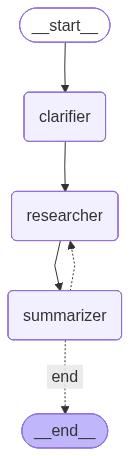

Graph structure:
START → clarifier → researcher → summarizer → END
           ↑            ↓
           └─(if <3 papers)


In [6]:
from IPython.display import Image, display
    
# Generate graph visualization as PNG
display(Image(streaming_graph.get_graph().draw_mermaid_png()))
print("Graph structure:")
print("START → clarifier → researcher → summarizer → END")
print("           ↑            ↓")
print("           └─(if <3 papers)")

## Streaming

**LangGraph streaming modes** provide different granularities of real-time updates:

| Mode | What it shows | Use case |
|------|---------------|----------|
| `"messages"` | **Token-level** LLM output as it's generated | Typewriter effect, real-time LLM thinking |
| `"updates"` | **Node-level** state changes after each node completes | Track agent progress, debug workflow |
| `"custom"` | **Tool progress** custom messages from tools | ArXiv search progress, file operations |

You can **combine multiple modes** in a single stream for complete visibility.

### Test 1: Token-Level Streaming (`stream_mode="messages"`)

**What**: Stream individual tokens as the LLM generates them (typewriter effect).

**How**: Each chunk is a tuple `(message, metadata)` where:
- `message.content` contains the token(s)
- `metadata["langgraph_node"]` tells you which node emitted it

**When to use**: Show live LLM output, create interactive UIs

In [9]:
import sys

# Thread ID tracks conversation history (checkpoints are stored per thread)
config_token = {"configurable": {"thread_id": "demo-stream-4"}}

question = "What is attention mechanism in transformers?"

initial_state = {
    "query": question,
    "llm_model": LLM_MODEL,
    "llm_temperature": 0,
    "max_papers": 3,
    "max_iterations": 2,
}

print("🚀 Watching LLM token generation in real-time...\n")
print("=" * 80)

in_summarizer = False

# stream_mode="messages" → Get token-level chunks as LLM generates
async for chunk in streaming_graph.astream(
    initial_state,
    config=config_token,
    stream_mode="messages"  # Each chunk = (message, metadata)
):
    message, metadata = chunk
    
    # Filter to only show summarizer node output
    node_name = metadata.get("langgraph_node", "")
    
    if node_name == "summarizer":
        if not in_summarizer:
            print("\n📝 SUMMARIZER (streaming tokens):")
            print("-" * 80)
            in_summarizer = True
        
        # Print tokens as they arrive (creates typewriter effect)
        if hasattr(message, 'content') and message.content:
            print(message.content, end='', flush=True)
    elif in_summarizer and node_name != "summarizer":
        print("\n" + "-" * 80)
        in_summarizer = False

print("\n" + "=" * 80)
print("\n✅ Token streaming complete!")

2025-11-16 12:17:04,749 - INFO - Clarifying query: 'What is attention mechanism in transformers?'


🚀 Watching LLM token generation in real-time...



2025-11-16 12:17:08,259 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:17:08,336 - INFO - Refined query: 'Transformer self-attention scaled dot-product query key value'
2025-11-16 12:17:09,970 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:17:09,997 - INFO - 🔍 Searching ArXiv: 'Transformer self-attention scaled dot-product query key value' (iteration 0)
2025-11-16 12:17:10,621 - INFO - Found 3 papers
2025-11-16 12:17:10,622 - INFO - Scoring paper relevance...
2025-11-16 12:17:10,629 - INFO -   📄 Attention Guided CAM: Visual Explanations of Vision Transfor... - Score: 60
2025-11-16 12:17:10,633 - INFO -   📄 Primal-Attention: Self-attention through Asymmetric Kernel S... - Score: 92
2025-11-16 12:17:10,636 - INFO -   📄 Toward Interpretable Music Tagging with Self-Attention... - Score: 75
2025-11-16 12:17:12,384 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completi


📝 SUMMARIZER (streaming tokens):
--------------------------------------------------------------------------------
## Résumé
• Attention in transformers is an operation that computes, for each position, a weighted sum of value vectors where weights come from compatibility between a query and keys — in practice implemented as self-attention that relates different sequence positions to build contextualized representations [Paper 1, Paper 2].  
• In Transformer architectures (including Vision Transformers), attention replaces recurrence/convolution: multi‑head scaled dot‑product attention lets the model attend to multiple types of relations in parallel and capture long‑range dependencies in a single layer [Paper 2, Paper 3].  
• Researchers analyze and improve attention both practically and theoretically: kernel and linear‑algebra views (e.g., asymmetric kernel SVD) aim to explain and make self‑attention more efficient or interpretable, while task‑specific studies probe how attention maps

2025-11-16 12:17:32,952 - INFO - ✅ Summary generated
2025-11-16 12:17:36,330 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


## Résumé
• Attention in transformers is an operation that computes, for each position, a weighted sum of value vectors where weights come from compatibility between a query and keys — in practice implemented as self-attention that relates different sequence positions to build contextualized representations [Paper 1, Paper 2].  
• In Transformer architectures (including Vision Transformers), attention replaces recurrence/convolution: multi‑head scaled dot‑product attention lets the model attend to multiple types of relations in parallel and capture long‑range dependencies in a single layer [Paper 2, Paper 3].  
• Researchers analyze and improve attention both practically and theoretically: kernel and linear‑algebra views (e.g., asymmetric kernel SVD) aim to explain and make self‑attention more efficient or interpretable, while task‑specific studies probe how attention maps relate to semantic cues in music and vision [Paper 1, Paper 2, Paper 3].  
• Attention is widely useful but not al

### Test 2: Node-Level Streaming (`stream_mode="updates"`)

**What**: Get state updates after each node completes.

**How**: Each event is a dict `{node_name: state_update}` containing only the fields that changed.

**When to use**: Track workflow progress, show which step is running, debug state flow

In [11]:
config_stream = {"configurable": {"thread_id": "demo-stream-1"}}

question = "What are recent advances in graph neural networks?"

initial_state = {
    "query": question,
    "llm_model": LLM_MODEL,
    "llm_temperature": 0,
    "max_papers": 3,
    "max_iterations": 2,
}

print("🚀 Starting graph with agent progress streaming...\n")
print("=" * 80)

# stream_mode="updates" → Get state changes after each node
async for event in streaming_graph.astream(
    initial_state,
    config=config_stream,
    stream_mode="updates"  # event = {node_name: state_update}
):
    for node_name, state_update in event.items():
        print(f"\n📍 Node: {node_name}")
        print("-" * 80)
        
        # Show key state changes (only modified fields are included)
        if "refined_query" in state_update:
            print(f"  ✨ Refined query: {state_update['refined_query']}")
        
        if "papers" in state_update:
            papers = state_update["papers"]
            print(f"  📚 Papers found: {len(papers)}")
            for i, paper in enumerate(papers, 1):
                score = paper.get('relevance_score', 'N/A')
                print(f"     {i}. {paper['title'][:60]}... (Score: {score})")
        
        if "summary" in state_update and state_update["summary"] != "NEED_MORE_PAPERS":
            summary = state_update["summary"]
            print(f"  📝 Summary preview: {summary[:150]}...")
        
        if "iteration" in state_update:
            print(f"  🔄 Iteration: {state_update['iteration']}")

print("\n" + "=" * 80)
print("✅ Streaming complete!")

2025-11-16 12:18:39,282 - INFO - Clarifying query: 'What are recent advances in graph neural networks?'


🚀 Starting graph with agent progress streaming...



2025-11-16 12:18:46,318 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:18:46,334 - INFO - Refined query: 'graph neural networks recent advances survey 2022-2025'
2025-11-16 12:18:50,289 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:18:50,300 - INFO - 🔍 Searching ArXiv: 'graph neural networks recent advances survey 2022-2025' (iteration 0)



📍 Node: clarifier
--------------------------------------------------------------------------------
  ✨ Refined query: graph neural networks recent advances survey 2022-2025
  🔄 Iteration: 0


2025-11-16 12:18:51,094 - INFO - Found 3 papers
2025-11-16 12:18:51,095 - INFO - Scoring paper relevance...
2025-11-16 12:18:51,101 - INFO -   📄 The Deep Arbitrary Polynomial Chaos Neural Network or how De... - Score: 10
2025-11-16 12:18:51,104 - INFO -   📄 A Review on Neural Network Models of Schizophrenia and Autis... - Score: 5
2025-11-16 12:18:51,107 - INFO -   📄 Learning Active Subspaces and Discovering Important Features... - Score: 3
2025-11-16 12:18:52,826 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:18:52,845 - INFO - 📝 Synthesizing 3 papers with streaming...



📍 Node: researcher
--------------------------------------------------------------------------------
  📚 Papers found: 3
     1. The Deep Arbitrary Polynomial Chaos Neural Network or how De... (Score: 10)
     2. A Review on Neural Network Models of Schizophrenia and Autis... (Score: 5)
     3. Learning Active Subspaces and Discovering Important Features... (Score: 3)
  🔄 Iteration: 1


2025-11-16 12:19:09,460 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:19:16,924 - INFO - ✅ Summary generated
2025-11-16 12:19:18,992 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



📍 Node: summarizer
--------------------------------------------------------------------------------
  📝 Summary preview: ## Résumé
• The three provided papers do not study graph neural networks directly; they report advances in different neural‑network subfields (data‑dr...

✅ Streaming complete!


### Test 3: Custom Progress Streaming (`stream_mode="custom"`)

**What**: Custom progress messages emitted by tools using `writer.write()`.

**How**: Tools can send progress updates (e.g., "Found 3/5 papers...") during execution.

**When to use**: Long-running operations, show fine-grained tool progress

In [12]:
config_custom = {"configurable": {"thread_id": "demo-stream-2"}}

question = "Explain vision transformers"

initial_state = {
    "query": question,
    "llm_model": LLM_MODEL,
    "llm_temperature": 0,
    "max_papers": 5,
    "max_iterations": 2,
}

print("🚀 Starting graph with custom progress streaming...\n")
print("=" * 80)

# stream_mode="custom" → Get custom progress messages from tools
# (requires tools to use `writer.write(message)` to emit updates)
async for event in streaming_graph.astream(
    initial_state,
    config=config_custom,
    stream_mode="custom"
):
    # Custom events are the raw messages emitted by tools
    print(f"  {event}")

print("\n" + "=" * 80)
print("✅ Custom streaming complete!")

2025-11-16 12:20:10,751 - INFO - Clarifying query: 'Explain vision transformers'
2025-11-16 12:20:10,758 - INFO - Refined query: 'Vision Transformer ViT architecture self-attention patch embeddings'
2025-11-16 12:20:10,759 - INFO - 🔍 Searching ArXiv: 'Vision Transformer ViT architecture self-attention patch embeddings' (iteration 0)


🚀 Starting graph with custom progress streaming...

  Starting ArXiv search for: 'Vision Transformer ViT architecture self-attention patch embeddings'


2025-11-16 12:20:11,430 - INFO - Found 5 papers
2025-11-16 12:20:11,430 - INFO - Scoring paper relevance...


  Found paper 1/5: Attention Guided CAM: Visual Explanations of Vision Transfor...
  Found paper 2/5: Evo-ViT: Slow-Fast Token Evolution for Dynamic Vision Transf...
  Found paper 3/5: Jigsaw-ViT: Learning Jigsaw Puzzles in Vision Transformer...
  Found paper 4/5: Tokens-to-Token ViT: Training Vision Transformers from Scrat...
  Found paper 5/5: V2X-ViT: Vehicle-to-Everything Cooperative Perception with V...
  ✅ Search complete: 5 papers found


2025-11-16 12:20:14,748 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:20:14,755 - INFO -   📄 Attention Guided CAM: Visual Explanations of Vision Transfor... - Score: 75
2025-11-16 12:20:19,237 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:20:19,249 - INFO -   📄 Evo-ViT: Slow-Fast Token Evolution for Dynamic Vision Transf... - Score: 65
2025-11-16 12:20:22,995 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:20:23,005 - INFO -   📄 Jigsaw-ViT: Learning Jigsaw Puzzles in Vision Transformer... - Score: 75
2025-11-16 12:20:25,897 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:20:25,908 - INFO -   📄 Tokens-to-Token ViT: Training Vision Transformers from Scrat... - Score: 92
2025-11-16 12:20:28,911 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTT


✅ Custom streaming complete!


### Test 4: Multi-Mode Streaming (Combined)

**What**: Combine multiple streaming modes for complete visibility.

**How**: Pass a list `["updates", "messages", "custom"]` and each event becomes a tuple `(mode, data)`.

**When to use**: Debugging, building rich UIs with multiple feedback layers

In [14]:
config_multi = {"configurable": {"thread_id": "demo-stream-3"}}

question = "What is few-shot learning?"

initial_state = {
    "query": question,
    "llm_model": LLM_MODEL,
    "llm_temperature": 0,
    "max_papers": 3,
    "max_iterations": 2,
}

print("🚀 Starting graph with multi-mode streaming...\n")
print("=" * 80)

# Multiple streaming modes → Events become tuples (mode, data)
async for event in streaming_graph.astream(
    initial_state,
    config=config_multi,
    stream_mode=["updates", "messages", "custom"]  # Combine all modes
):
    stream_mode, data = event
    
    if stream_mode == "updates":
        # Node-level updates
        if isinstance(data, dict):
            for node_name, state_update in data.items():
                print(f"\n🔷 NODE UPDATE: {node_name}")
                
                if isinstance(state_update, dict):
                    if "refined_query" in state_update:
                        print(f"   ✨ Refined query: {state_update['refined_query']}")
                    
                    if "papers" in state_update:
                        papers = state_update['papers']
                        if isinstance(papers, list):
                            print(f"   📚 Papers: {len(papers)} found")
                    
                    if "summary" in state_update and state_update["summary"] != "NEED_MORE_PAPERS":
                        print(f"   📝 Summary generated")
    
    elif stream_mode == "messages":
        # Token-level streaming
        message, metadata = data
        node_name = metadata.get("langgraph_node", "")
        
        # Show only summarizer tokens (comment out to see all)
        if node_name == "summarizer" and hasattr(message, 'content') and message.content:
            print(message.content, end='', flush=True)
    
    elif stream_mode == "custom":
        # Custom tool progress
        print(f"🔶 PROGRESS: {data}")

print("\n" + "=" * 80)
print("✅ Multi-mode streaming complete!")

2025-11-16 12:21:40,981 - INFO - Clarifying query: 'What is few-shot learning?'


🚀 Starting graph with multi-mode streaming...



2025-11-16 12:21:46,865 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:21:47,019 - INFO - Refined query: 'few-shot learning survey definition meta-learning metric-learning'



🔷 NODE UPDATE: clarifier
   ✨ Refined query: few-shot learning survey definition meta-learning metric-learning


2025-11-16 12:21:48,251 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:21:48,256 - INFO - 🔍 Searching ArXiv: 'few-shot learning survey definition meta-learning metric-learning' (iteration 0)


🔶 PROGRESS: Starting ArXiv search for: 'few-shot learning survey definition meta-learning metric-learning'


2025-11-16 12:21:49,100 - INFO - Found 3 papers
2025-11-16 12:21:49,101 - INFO - Scoring paper relevance...
2025-11-16 12:21:49,110 - INFO -   📄 Few-shot Learning with Meta Metric Learners... - Score: 90
2025-11-16 12:21:49,115 - INFO -   📄 Regression Networks for Meta-Learning Few-Shot Classificatio... - Score: 90


🔶 PROGRESS: Found paper 1/3: Few-shot Learning with Meta Metric Learners...
🔶 PROGRESS: Found paper 2/3: Regression Networks for Meta-Learning Few-Shot Classificatio...
🔶 PROGRESS: Found paper 3/3: Meta-Baseline: Exploring Simple Meta-Learning for Few-Shot L...
🔶 PROGRESS: ✅ Search complete: 3 papers found


2025-11-16 12:21:52,036 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:21:52,073 - INFO -   📄 Meta-Baseline: Exploring Simple Meta-Learning for Few-Shot L... - Score: 95



🔷 NODE UPDATE: researcher
   📚 Papers: 3 found


2025-11-16 12:21:53,801 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:21:53,816 - INFO - 📝 Synthesizing 4 papers with streaming...
2025-11-16 12:22:05,979 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


## Résumé
• Few‑shot learning studies how to train classifiers that can recognize new classes from only a handful of labeled examples — the goal is to generalize to novel categories with minimal data (typical setups are “N‑way K‑shot”). It emphasizes task-level generalization rather than improving performance on classes seen during training [Paper 2, Paper 3].  
• Two broad families of methods are common: meta‑learning (train a learner over many small tasks to fast‑adapt) and metric‑learning (learn embeddings or similarity rules to compare examples); regression‑based approaches instead predict classifiers or similarity along directional features in embedding space. These families trade off flexibility, simplicity, and assumptions about task homogeneity [Paper 1, Paper 2, Paper 3].  
• Empirical work shows simple baselines can be surprisingly strong: training on whole‑classification (standard multiclass training) or careful baseline designs can rival more complex meta‑learning schemes, 

2025-11-16 12:22:14,141 - INFO - ✅ Summary generated
2025-11-16 12:22:15,463 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


## Résumé
• Few‑shot learning studies how to train classifiers that can recognize new classes from only a handful of labeled examples — the goal is to generalize to novel categories with minimal data (typical setups are “N‑way K‑shot”). It emphasizes task-level generalization rather than improving performance on classes seen during training [Paper 2, Paper 3].  
• Two broad families of methods are common: meta‑learning (train a learner over many small tasks to fast‑adapt) and metric‑learning (learn embeddings or similarity rules to compare examples); regression‑based approaches instead predict classifiers or similarity along directional features in embedding space. These families trade off flexibility, simplicity, and assumptions about task homogeneity [Paper 1, Paper 2, Paper 3].  
• Empirical work shows simple baselines can be surprisingly strong: training on whole‑classification (standard multiclass training) or careful baseline designs can rival more complex meta‑learning schemes, 

## Interrupts (Human-in-the-Loop)

**Interrupts** pause execution for human review/approval. This enables:

- ✅ **Approval workflows**: Review agent decisions before proceeding
- ✏️ **State editing**: Modify the plan/query before continuing  
- ❌ **Cancellation**: Stop execution if the agent goes off-track

**Key concepts**:
- `interrupt_before=["node"]` → Pause **before** a node executes
- `interrupt_after=["node"]` → Pause **after** a node completes
- `graph.update_state()` → Modify state at interrupt point
- `graph.stream(None, config)` → Resume from last checkpoint

### Test 5: Basic Interruption

**Pattern**: 
1. Set `interrupt_after=["clarifier"]` when creating graph
2. Run until interrupt → receives `{'__interrupt__': ()}`
3. Inspect state with `graph.get_state(config)`
4. Optionally edit state with `graph.update_state()`
5. Resume with `graph.stream(None, config)`

In [15]:
from src.agent_graph.graph import create_graph

# 1. Create graph with interrupt after clarifier node
graph = create_graph(with_checkpointer=True, interrupt_after=["clarifier"])

config = {"configurable": {"thread_id": "demo-interrupt-1"}}

question = "What are the key innovations in LSTM?"

initial_state = {
    "query": question,
    "llm_model": LLM_MODEL,
    "llm_temperature": 0,
    "max_papers": 5,
    "max_iterations": 2,
}

# 2. Run until first interrupt
for event in graph.stream(initial_state, config):
    print(event)  # You'll see {'__interrupt__': ()} when it pauses

2025-11-16 12:22:29,753 - INFO - Clarifying query: 'What are the key innovations in LSTM?'
2025-11-16 12:22:29,758 - INFO - Refined query: 'LSTM gating mechanisms forget gate peephole connections'


{'clarifier': {'refined_query': 'LSTM gating mechanisms forget gate peephole connections', 'iteration': 0, 'messages': [HumanMessage(content='What are the key innovations in LSTM?', additional_kwargs={}, response_metadata={}, name='User'), AIMessage(content='Refined query: LSTM gating mechanisms forget gate peephole connections', additional_kwargs={}, response_metadata={}, name='Clarifier')]}}
{'__interrupt__': ()}


In [16]:
# 3. Inspect state at the interrupt point
state = graph.get_state(config)

print("Current state values:")
print(state.values)  # See full current state

print("\nNext node to execute:")
print(state.next)  # Shows ('researcher',) - the next pending node

Current state values:
{'query': 'What are the key innovations in LSTM?', 'llm_model': 'gpt-5-mini', 'llm_temperature': 0, 'max_papers': 5, 'max_iterations': 2, 'papers': [], 'messages': [HumanMessage(content='What are the key innovations in LSTM?', additional_kwargs={}, response_metadata={}, name='User'), AIMessage(content='Refined query: LSTM gating mechanisms forget gate peephole connections', additional_kwargs={}, response_metadata={}, name='Clarifier')], 'refined_query': 'LSTM gating mechanisms forget gate peephole connections', 'iteration': 0}

Next node to execute:
('researcher',)


In [17]:
# 4. Modify state before resuming
graph.update_state(
    config,
    {"refined_query": "LSTM advanced architectures"},  # Edit the query
)

print("✏️ Updated refined_query\n")

# 5. Resume execution from checkpoint
# None = resume from last checkpoint (don't restart)
for event in graph.stream(None, config):
    print(event)

2025-11-16 12:22:29,801 - INFO - Searching ArXiv: 'LSTM advanced architectures' (iteration 0)


✏️ Updated refined_query

5 max_papers
max_results tool 5


2025-11-16 12:22:31,092 - INFO - Found 5 papers
2025-11-16 12:22:31,094 - INFO - Scoring paper relevance...
2025-11-16 12:22:31,098 - INFO -   📄 Vision-LSTM: xLSTM as Generic Vision Backbone... - Score: 45
2025-11-16 12:22:31,100 - INFO -   📄 The application of collagen in advanced wound dressings... - Score: 1
2025-11-16 12:22:31,102 - INFO -   📄 Predicting the Accuracy of Early-est Earthquake Magnitude Es... - Score: 10
2025-11-16 12:22:33,280 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:22:33,290 - INFO -   📄 Advanced Drone Swarm Security by Using Blockchain Governance... - Score: 1
2025-11-16 12:22:33,293 - INFO -   📄 Leveraging LSTM for Predictive Modeling of Satellite Clock B... - Score: 10
2025-11-16 12:22:33,296 - INFO - 📝 Synthesizing 5 papers...


{'researcher': {'papers': [{'id': 'http://arxiv.org/abs/2406.04303v3', 'title': 'Vision-LSTM: xLSTM as Generic Vision Backbone', 'authors': ['Benedikt Alkin', 'Maximilian Beck', 'Korbinian Pöppel', 'Sepp Hochreiter', 'Johannes Brandstetter'], 'summary': 'Transformers are widely used as generic backbones in computer vision, despite initially introduced for natural language processing. Recently, the Long Short-Term Memory (LSTM) has been extended to a scalable and performant architecture - the xLSTM - which overcomes long-standing LSTM limitations via exponential gating and parallelizable matrix memory structure. In this report, we introduce Vision-LSTM (ViL), an adaption of the xLSTM building blocks to computer vision. ViL comprises a stack of xLSTM blocks where odd blocks process the sequence of patch tokens from top to bottom while even blocks go from bottom to top. Experiments show that ViL holds promise to be further deployed as new generic backbone for computer vision architectures

2025-11-16 12:22:54,172 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:22:54,195 - INFO - ✅ Summary generated


{'summarizer': {'summary': '## Résumé\n• LSTM’s core innovation is a gated memory cell that lets networks store and selectively update information over long time spans, which mitigates vanishing gradients and enables learning long-term dependencies in sequential data [Paper 2, Paper 3].  \n• Recent architectural advances extend that idea: xLSTM introduces exponential gating and a parallelizable matrix memory structure to overcome traditional LSTM scalability and performance limits, making LSTM-style modules more competitive as large backbones (e.g., for vision) [Paper 1].  \n• In practice, LSTM variants excel at real-time sequence forecasting and noisy temporal signals, as shown by applications to early earthquake-magnitude estimation and satellite clock-bias prediction—demonstrating robustness to short noisy windows and usefulness after domain-specific preprocessing and normalization [Paper 2, Paper 3].  \n• Deployment and performance depend heavily on implementation choices (normaliz

### Test 6: Approval Workflow with User Input

**Pattern**: Interactive human approval with three options:
- ✅ **Approve**: Continue as-is
- ✏️ **Edit**: Modify the query
- ❌ **Cancel**: Stop execution

In [18]:
from src.agent_graph.graph import create_graph

# Use both interrupt_before and interrupt_after for demonstration
graph = create_graph(
    with_checkpointer=True, 
    interrupt_before=["researcher"],  # Pause BEFORE researcher runs
    interrupt_after=["clarifier"]     # Pause AFTER clarifier completes
)

config = {"configurable": {"thread_id": "demo-interrupt-2"}}

question = "What are the key innovations in LSTM?"

initial_state = {
    "query": question,
    "llm_model": LLM_MODEL,
    "llm_temperature": 0,
    "max_papers": 5,
    "max_iterations": 2,
}

# Run until interrupt
for event in graph.stream(initial_state, config, stream_mode="updates"):
    for node_name, state_update in event.items():
        print(f"✅ {node_name} completed")
        if "refined_query" in state_update:
            print(f"   Refined query: {state_update['refined_query']}")

# Execution is paused - human reviews
print("\n⏸️  Execution paused before researcher node")
state_snapshot = graph.get_state(config)
    
# Get human approval/feedback
refined_query = state_snapshot.values['refined_query']
print(f"\n📋 Proposed search query: '{refined_query}'")
approval = input("Approve this query? (y/n/edit): ").strip().lower()

if approval == 'n':
    print("❌ Search cancelled")
elif approval == 'edit':
    new_query = input("Enter new query: ").strip()
    # Modify state before resuming
    graph.update_state(config, {"refined_query": new_query})
    print(f"✏️  Updated query to: '{new_query}'")

    # Resume execution
    print("\n▶️  Resuming execution...\n")
    for event in graph.stream(None, config, stream_mode="updates"):
        for node_name, state_update in event.items():
            print(f"✅ {node_name} completed")
else:  # 'y'
    print("✅ Approved - continuing...\n")
    # Resume without changes
    for event in graph.stream(None, config, stream_mode="updates"):
        for node_name, state_update in event.items():
            print(f"✅ {node_name} completed")

print("\n🏁 Workflow complete!")

2025-11-16 12:22:54,260 - INFO - Clarifying query: 'What are the key innovations in LSTM?'
2025-11-16 12:22:54,265 - INFO - Refined query: 'LSTM gating mechanisms forget gate peephole connections'


✅ clarifier completed
   Refined query: LSTM gating mechanisms forget gate peephole connections
✅ __interrupt__ completed

⏸️  Execution paused before researcher node

📋 Proposed search query: 'LSTM gating mechanisms forget gate peephole connections'


2025-11-16 12:25:10,824 - INFO - Searching ArXiv: 'LSTM advanced' (iteration 0)


✏️  Updated query to: 'LSTM advanced'

▶️  Resuming execution...

5 max_papers
max_results tool 5


2025-11-16 12:25:11,355 - INFO - Found 5 papers
2025-11-16 12:25:11,357 - INFO - Scoring paper relevance...
2025-11-16 12:25:11,367 - INFO -   📄 The application of collagen in advanced wound dressings... - Score: 1
2025-11-16 12:25:11,369 - INFO -   📄 Predicting the Accuracy of Early-est Earthquake Magnitude Es... - Score: 10
2025-11-16 12:25:11,373 - INFO -   📄 Vision-LSTM: xLSTM as Generic Vision Backbone... - Score: 45
2025-11-16 12:25:11,374 - INFO -   📄 Leveraging LSTM for Predictive Modeling of Satellite Clock B... - Score: 10
2025-11-16 12:25:11,376 - INFO -   📄 Advanced Drone Swarm Security by Using Blockchain Governance... - Score: 1
2025-11-16 12:25:11,379 - INFO - 📝 Synthesizing 5 papers...
2025-11-16 12:25:11,382 - INFO - ✅ Summary generated


✅ researcher completed
✅ summarizer completed

🏁 Workflow complete!


In [19]:
graph.get_state(config).values.get("refined_query")

'LSTM advanced'

### Test 7: Interrupt Node (Built-in Approval Pattern)

**Advanced pattern**: Create a dedicated **approval node** that:
1. Uses `interrupt()` to pause execution *within* the node
2. Returns data to the user via the interrupt value
3. Receives user response via `Command(resume=...)`

This is cleaner than `interrupt_before/after` for complex approval logic.

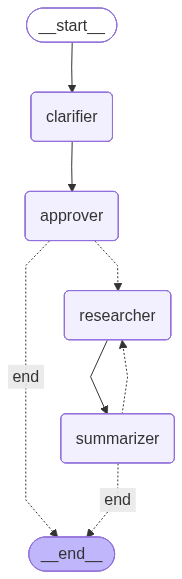

In [20]:
from IPython.display import Image, display
from src.agent_graph.graph import create_graph_with_approval

graph = create_graph_with_approval()

# Generate graph visualization as PNG
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
from langgraph.types import Command

config = {"configurable": {"thread_id": "approval-node-demo"}}
initial_state = {
    "query": "What is attention mechanism?",
    "llm_model": LLM_MODEL,
    "max_papers": 5,
}

print("🚀 Starting workflow with approval node...\n")

# Run until the approval node interrupts
for event in graph.stream(initial_state, config, stream_mode="updates"):
    for node_name, _ in event.items():
        print(f"✅ {node_name} completed")

# The approval node has paused execution using interrupt()
print("\n⏸️  Approval node has paused execution")
state = graph.get_state(config)

# Extract the interrupt value (contains the message for user)
interrupt_value = None
for task in state.tasks:
    if task.interrupts:
        interrupt_value = task.interrupts[0].value
        break

if interrupt_value:
    print(f"\n{interrupt_value['message']}")

# Get user decision
user_response = input("\nYour choice: ").strip().lower()

# Build response based on user choice
if user_response == "cancel":
    resume_value = {"action": "cancel"}
    print("\n❌ Workflow cancelled by user")
    
elif user_response == "edit":
    new_query = input("Enter your improved query: ").strip()
    resume_value = {"action": "edit", "new_query": new_query}
    
else:  # assume approve
    resume_value = {"action": "approve"}

# Resume execution by passing the response
# Command(resume=...) sends the value back to the interrupt() call
print("\n▶️  Resuming with your decision...\n")

for event in graph.stream(
    Command(resume=resume_value),  # This "answers" the interrupt
    config,
    stream_mode="updates"
):
    for node_name, _ in event.items():
        print(f"✅ {node_name} completed")

print("\n🏁 Workflow complete!")

# Display final summary
final_state = graph.get_state(config)

if final_state.values.get("approved", False):
    summary = final_state.values.get("summary", "")
    papers = final_state.values.get("papers", [])
    
    if summary and summary != "NEED_MORE_PAPERS":
        print("\n" + "=" * 80)
        print("📄 FINAL SUMMARY")
        print("=" * 80)
        print(f"\n{summary}\n")
        print("=" * 80)
        print(f"\n✅ Successfully summarized {len(papers)} papers")
    else:
        print("\n⚠️  Summary not generated (insufficient papers or still processing)")
else:
    print("\n❌ Workflow was cancelled - no summary generated")

2025-11-16 12:25:11,764 - INFO - Clarifying query: 'What is attention mechanism?'


🚀 Starting workflow with approval node...



2025-11-16 12:25:19,712 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:25:19,725 - INFO - Refined query: 'attention mechanisms neural networks survey self-attention transformer'


✅ clarifier completed
✅ __interrupt__ completed

⏸️  Approval node has paused execution

The clarifier suggests this search query:

   'attention mechanisms neural networks survey self-attention transformer'

What would you like to do?
  - Type 'approve' to continue
  - Type 'edit' to modify the query
  - Type 'cancel' to stop


2025-11-16 12:25:33,937 - INFO - Searching ArXiv: 'attention mechanism basocs' (iteration 0)



▶️  Resuming with your decision...

✅ approver completed
5 max_papers
max_results tool 5


2025-11-16 12:25:34,327 - INFO - Found 5 papers
2025-11-16 12:25:34,329 - INFO - Scoring paper relevance...
2025-11-16 12:25:38,801 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:25:38,818 - INFO -   📄 Déjà vu: A Contextualized Temporal Attention Mechanism for S... - Score: 45
2025-11-16 12:25:41,291 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:25:41,300 - INFO -   📄 Synthesis of Mechanism for single- and hybrid-tasks using Di... - Score: 1
2025-11-16 12:25:43,644 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:25:43,653 - INFO -   📄 Synthesis of Spherical 4R Mechanism for Path Generation usin... - Score: 1
2025-11-16 12:25:47,119 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:25:47,137 - INFO -   📄 Pay Attention to What You Need... - Score: 85
2025-11-16 12:25:50,

✅ researcher completed


2025-11-16 12:26:14,231 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:26:14,270 - INFO - ✅ Summary generated
2025-11-16 12:26:16,510 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


✅ summarizer completed

🏁 Workflow complete!

📄 FINAL SUMMARY

## Résumé
• Mécanisme de base : l'attention calcule des poids (scores) qui indiquent la pertinence relative de chaque élément d'entrée, puis utilise ces poids pour faire une combinaison pondérée des représentations — cela permet au modèle de « se concentrer » sur les parties les plus utiles d'un contexte au moment du calcul. L'idée est au cœur des architectures comme le Transformer et remplace/complète les approches séquentielles classiques. [Paper 2, Paper 1]

• Usage dans les grands modèles et contexte long : dans les LLMs, l'attention permet de relier des tokens éloignés, mais la gestion de contextes très longs pose des défis de calcul et de qualité ; des travaux proposent d'adapter l'attention (sélection de tokens pertinents, modifications d'architecture) pour conserver l'information utile sans retrain massif. Ces approches ciblent un compromis entre précision et coût pratique pour déployer des modèles légers. [Paper 1]

## Time Travel (State Rewinding & Branching)

**Time travel** leverages checkpoint history to:

- ⏪ **Rewind**: Go back to a previous state and modify it
- 🔀 **Branch**: Create parallel timelines for A/B testing
- 🐛 **Debug**: Replay from any point in execution history

**Key concepts**:
- `graph.get_state_history(config)` → Access all checkpoints for a thread
- `graph.update_state(..., as_node="node_name")` → Rewind to after that node ran
- Different `thread_id` → Independent execution branches

### Test 8: Rewind and Fix

**Scenario**: Agent runs with ambiguous query, produces poor results. We rewind to the clarifier step and fix the query.

**Pattern**:
1. Run workflow to completion
2. Browse checkpoint history
3. Find the node to rewind to
4. Use `update_state(..., as_node="clarifier")` to rewind
5. Re-run from that point forward

In [22]:
from src.agent_graph.graph import create_graph

graph = create_graph(with_checkpointer=True)

config = {"configurable": {"thread_id": "time-travel-demo"}}
initial_state = {
    "query": "What are transformers?",  # Ambiguous! Could mean neural nets or electrical
    "llm_model": LLM_MODEL,
    "max_papers": 5,
}

print("🚀 Running workflow with ambiguous query...\n")

# Run to completion
for event in graph.stream(initial_state, config, stream_mode="updates"):
    for node_name, state_update in event.items():
        print(f"✅ {node_name} completed")
        if "refined_query" in state_update:
            print(f"   Query: {state_update['refined_query']}")

# Check the final summary
final_state = graph.get_state(config)
summary = final_state.values.get('summary', '')

print("\n📄 FINAL SUMMARY")
print(summary[:500] + "..." if len(summary) > 500 else summary)

2025-11-16 12:26:16,639 - INFO - Clarifying query: 'What are transformers?'
2025-11-16 12:26:16,643 - INFO - Refined query: 'Transformer neural network architecture attention mechanism Vaswani'
2025-11-16 12:26:16,644 - INFO - Searching ArXiv: 'Transformer neural network architecture attention mechanism Vaswani' (iteration 0)


🚀 Running workflow with ambiguous query...

✅ clarifier completed
   Query: Transformer neural network architecture attention mechanism Vaswani
5 max_papers
max_results tool 5


2025-11-16 12:26:16,726 - INFO - Found 5 papers
2025-11-16 12:26:16,727 - INFO - Scoring paper relevance...
2025-11-16 12:26:16,731 - INFO -   📄 Music Transformer... - Score: 45
2025-11-16 12:26:16,736 - INFO -   📄 A Tutorial about Random Neural Networks in Supervised Learni... - Score: 3
2025-11-16 12:26:16,739 - INFO -   📄 Architectural Implications of Graph Neural Networks... - Score: 5
2025-11-16 12:26:16,741 - INFO -   📄 Partial Connection Based on Channel Attention for Differenti... - Score: 5
2025-11-16 12:26:16,743 - INFO -   📄 Trading with the Momentum Transformer: An Intelligent and In... - Score: 30
2025-11-16 12:26:16,744 - INFO - 📝 Synthesizing 5 papers...
2025-11-16 12:26:16,748 - INFO - ✅ Summary generated


✅ researcher completed
✅ summarizer completed

📄 FINAL SUMMARY
## Résumé
• Transformers are neural sequence models that replace recurrence with self-attention, giving each position direct, learned connections to all others; this enables modeling long-range dependencies and efficient parallel training [Paper 1, Paper 2].  
• They are widely adaptable: variants like the Music Transformer use attention to capture musical repetition and structure over long timescales, while the Momentum Transformer applies attention to financial time series for interpretable mo...


In [23]:
# Browse checkpoint history
history = list(graph.get_state_history(config))

print("📜 Checkpoint History:\n")

# Find key checkpoints (after each node)
clarifier_checkpoint = None
researcher_checkpoint = None
summarizer_checkpoint = None

for checkpoint in history:
    # Check which node produced this checkpoint
    if "refined_query" in checkpoint.values and not clarifier_checkpoint:
        clarifier_checkpoint = checkpoint
        print(f"📍 After CLARIFIER:")
        print(f"   Query: {checkpoint.values['refined_query'][:60]}...")
        print(f"   Checkpoint ID: {checkpoint.config['configurable']['checkpoint_id'][:20]}...\n")
    
    if "papers" in checkpoint.values and checkpoint.values.get("papers") and not researcher_checkpoint:
        researcher_checkpoint = checkpoint
        print(f"📍 After RESEARCHER:")
        print(f"   Papers found: {len(checkpoint.values['papers'])}")
        print(f"   Checkpoint ID: {checkpoint.config['configurable']['checkpoint_id'][:20]}...\n")
    
    if "summary" in checkpoint.values and checkpoint.values.get("summary") != "NEED_MORE_PAPERS" and not summarizer_checkpoint:
        summarizer_checkpoint = checkpoint
        print(f"📍 After SUMMARIZER:")
        print(f"   Summary length: {len(checkpoint.values['summary'])} chars")
        print(f"   Checkpoint ID: {checkpoint.config['configurable']['checkpoint_id'][:20]}...\n")

# Rewind to clarifier node and fix the query
print("⏪ Rewinding to clarifier to fix ambiguous query...\n")

# as_node="clarifier" → Rewind to right after clarifier ran
# Clear downstream state to force re-execution
graph.update_state(
    config,
    {
        "refined_query": "transformer electrical power systems",
        "papers": [],      # Clear papers so researcher re-runs
        "summary": "",     # Clear summary so summarizer re-runs
        "iteration": 0
    },
    as_node="clarifier"  # Act as if clarifier just produced this state
)

print("✏️  Updated query to be more specific: 'transformer electrical power systems'")

📜 Checkpoint History:

📍 After CLARIFIER:
   Query: Transformer neural network architecture attention mechanism ...
   Checkpoint ID: 1f0c2df1-1052-6940-8...

📍 After RESEARCHER:
   Papers found: 5
   Checkpoint ID: 1f0c2df1-1052-6940-8...

📍 After SUMMARIZER:
   Summary length: 1908 chars
   Checkpoint ID: 1f0c2df1-1052-6940-8...

⏪ Rewinding to clarifier to fix ambiguous query...

✏️  Updated query to be more specific: 'transformer electrical power systems'


In [24]:
# Verify the rewind worked
current_state = graph.get_state(config)

print("Current refined_query:", current_state.values.get("refined_query"))
print("Papers in state:", len(current_state.values.get("papers", [])))
print("Next node to run:", current_state.next)

Current refined_query: transformer electrical power systems
Papers in state: 0
Next node to run: ('researcher',)


In [25]:
# (Optional) Remove this cell if not needed for demonstration

In [26]:
print("\n▶️  Re-running from researcher node with corrected query...\n")

# Resume from checkpoint - graph will execute researcher → summarizer
for event in graph.stream(None, config, stream_mode="updates"):
    for node_name, state_update in event.items():
        print(f"✅ {node_name} (re-executed)")

# Check the new result
new_final_state = graph.get_state(config)
new_summary = new_final_state.values['summary']

print("\n📄 NEW SUMMARY (after time travel)")
print(new_summary[:500] + "..." if len(new_summary) > 500 else new_summary)

2025-11-16 12:26:16,841 - INFO - Searching ArXiv: 'transformer electrical power systems' (iteration 0)



▶️  Re-running from researcher node with corrected query...

5 max_papers
max_results tool 5


2025-11-16 12:26:17,481 - INFO - Found 5 papers
2025-11-16 12:26:17,482 - INFO - Scoring paper relevance...
2025-11-16 12:26:21,425 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:26:21,438 - INFO -   📄 Parameterized Linear Power Flow for High Fidelity Voltage So... - Score: 3
2025-11-16 12:26:24,363 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:26:24,389 - INFO -   📄 A Strategy for Power System Stability Improvement via Contro... - Score: 1
2025-11-16 12:26:27,057 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:26:27,068 - INFO -   📄 PINNSim: A Simulator for Power System Dynamics based on Phys... - Score: 2
2025-11-16 12:26:31,059 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:26:31,067 - INFO -   📄 Electric Vehicle Attack Impact on Power Grid Operation... - Score: 

✅ researcher (re-executed)


2025-11-16 12:27:02,900 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-16 12:27:02,936 - INFO - ✅ Summary generated
2025-11-16 12:27:05,138 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


✅ summarizer (re-executed)

📄 NEW SUMMARY (after time travel)
## Résumé
• The set of provided papers do not define or study “transformers” (neither the electromagnetic device for voltage conversion nor the machine‑learning Transformer model). Instead, they address power‑system modeling, dynamics, gas–electric coupling, electric‑vehicle impacts, and simulation methods, so they cannot directly answer “What are transformers?” if you meant that term; ask and I will summarize transformers specifically [Paper 1, Paper 2, Paper 3, Paper 4, Paper 5].  
• Integrate...


### Test 9: Parallel Branches (A/B Testing)

**Scenario**: Run the same workflow with different parameters by branching from a checkpoint.

**Use case**: 
- Compare results with different `max_papers` settings
- Test different prompting strategies
- A/B test workflow variations

**Key insight**: Both branches reuse the expensive clarifier step!

In [27]:
from src.agent_graph.graph import create_graph

graph = create_graph(with_checkpointer=True)

initial_state = {
    "query": "What are transformers?",
    "llm_model": LLM_MODEL,
    "max_papers": 5,
}

# Run base workflow once
base_config = {"configurable": {"thread_id": "ab-test-base"}}
for event in graph.stream(initial_state, base_config):
    pass

# Find the clarifier checkpoint (the expensive LLM call we want to reuse)
history = list(graph.get_state_history(base_config))
clarifier_checkpoint = None
for checkpoint in reversed(history):  # Start from oldest
    if "refined_query" in checkpoint.values and checkpoint.values.get("refined_query"):
        clarifier_checkpoint = checkpoint
        break

print(f"✅ Base run complete. Clarifier produced: '{clarifier_checkpoint.values['refined_query']}'")
print(f"\nNow creating parallel branches to test different max_papers values...\n")

# Branch A: Test with 5 papers
branch_a_config = {"configurable": {"thread_id": "branch-5-papers"}}
graph.update_state(
    branch_a_config,
    {
        **clarifier_checkpoint.values,  # Copy the refined query
        "max_papers": 5,                # Set branch-specific parameter
        "papers": [],                   # Clear downstream state
        "summary": ""
    },
    as_node="clarifier"  # Start from after clarifier
)

# Branch B: Test with 10 papers
branch_b_config = {"configurable": {"thread_id": "branch-10-papers"}}
graph.update_state(
    branch_b_config,
    {
        **clarifier_checkpoint.values,
        "max_papers": 10,  # Different parameter
        "papers": [],
        "summary": ""
    },
    as_node="clarifier"
)

# Run both branches (they share the clarifier's work!)
print("Running Branch A (5 papers)...")
for event in graph.stream(None, branch_a_config):
    pass

print("Running Branch B (10 papers)...")
for event in graph.stream(None, branch_b_config):
    pass

# Compare results
result_a = graph.get_state(branch_a_config).values
result_b = graph.get_state(branch_b_config).values

print(f"\n📊 Comparison:")
print(f"  Branch A (5 papers):  {len(result_a['papers'])} papers, {len(result_a['summary'])} char summary")
print(f"  Branch B (10 papers): {len(result_b['papers'])} papers, {len(result_b['summary'])} char summary")
print(f"\nBoth branches reused the same clarifier result, saving 1 LLM call!")

2025-11-16 12:27:05,475 - INFO - Clarifying query: 'What are transformers?'
2025-11-16 12:27:05,479 - INFO - Refined query: 'Transformer neural network architecture attention mechanism Vaswani'
2025-11-16 12:27:05,480 - INFO - Searching ArXiv: 'Transformer neural network architecture attention mechanism Vaswani' (iteration 0)
2025-11-16 12:27:05,481 - INFO - Requesting page (first: True, try: 0): https://export.arxiv.org/api/query?search_query=Transformer+neural+network+architecture+attention+mechanism+Vaswani&id_list=&sortBy=relevance&sortOrder=descending&start=0&max_results=5
2025-11-16 12:27:05,641 - INFO - Got first page: 5 of 736477 total results
2025-11-16 12:27:05,644 - INFO - Found 5 papers
2025-11-16 12:27:05,644 - INFO - Scoring paper relevance...
2025-11-16 12:27:05,647 - INFO -   📄 Music Transformer... - Score: 45
2025-11-16 12:27:05,649 - INFO -   📄 A Tutorial about Random Neural Networks in Supervised Learni... - Score: 3
2025-11-16 12:27:05,651 - INFO -   📄 Architectural

✅ Base run complete. Clarifier produced: 'Transformer neural network architecture attention mechanism Vaswani'

Now creating parallel branches to test different max_papers values...

Running Branch A (5 papers)...
Running Branch B (10 papers)...


2025-11-16 12:27:06,001 - INFO - Got first page: 10 of 736477 total results
2025-11-16 12:27:06,004 - INFO - Found 10 papers
2025-11-16 12:27:06,006 - INFO - Scoring paper relevance...
2025-11-16 12:27:06,009 - INFO -   📄 Music Transformer... - Score: 45
2025-11-16 12:27:06,012 - INFO -   📄 A Tutorial about Random Neural Networks in Supervised Learni... - Score: 3
2025-11-16 12:27:06,014 - INFO -   📄 Architectural Implications of Graph Neural Networks... - Score: 5
2025-11-16 12:27:06,018 - INFO -   📄 Partial Connection Based on Channel Attention for Differenti... - Score: 5
2025-11-16 12:27:06,021 - INFO -   📄 Trading with the Momentum Transformer: An Intelligent and In... - Score: 30
2025-11-16 12:27:06,024 - INFO -   📄 Hierarchical Attentional Hybrid Neural Networks for Document... - Score: 20
2025-11-16 12:27:06,027 - INFO -   📄 Predicting concentration levels of air pollutants by transfe... - Score: 1
2025-11-16 12:27:06,031 - INFO -   📄 Neural Architecture Transfer... - Score: 8



📊 Comparison:
  Branch A (5 papers):  5 papers, 1908 char summary
  Branch B (10 papers): 10 papers, 3172 char summary

Both branches reused the same clarifier result, saving 1 LLM call!
